supply and demand analysis
calculate changes in oil reserves, including the SPR, weekly and compared to last year
determine if changes are in line with expectations
if not in line with expectations determine if it is do to higher demand, lower production, more exports or a combination

In [1]:
import pandas as pd
import USA_oil_data as oil
import prices
import FRED_oil_data as fred
import matplotlib.pyplot as plt

In [2]:
weekly_stocks = oil.weekly_stocks()
spr = oil.spr_reserves()

In [3]:
merged = pd.merge(weekly_stocks, spr, on='period')
merged.sort_index(inplace=True)

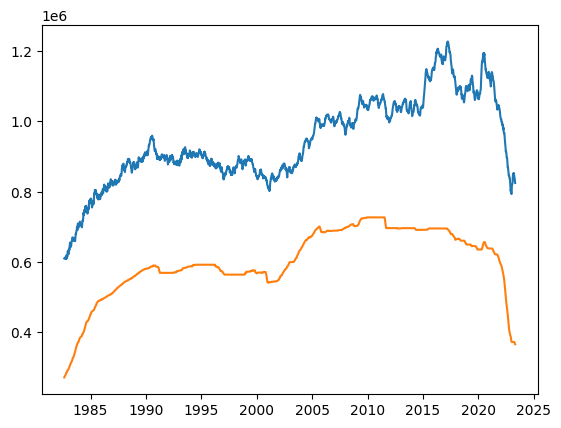

In [6]:
ticks = [x for x in range(0, 1400000, 200000)]

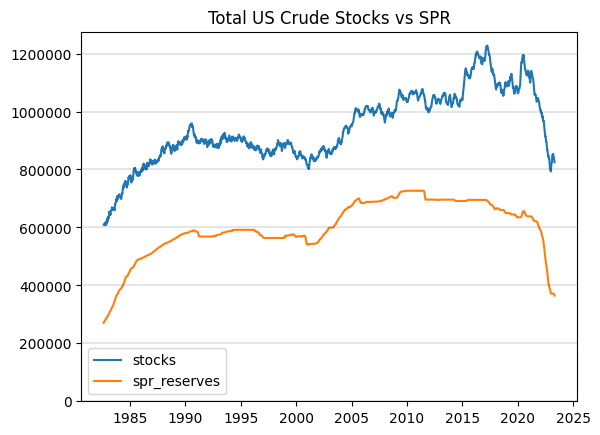

In [10]:
plt.plot(merged)

plt.yticks(ticks)
plt.ticklabel_format(axis='y', style='plain')
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)

plt.legend(merged.columns)
plt.title("Total US Crude Stocks vs SPR")
plt.show()